In [3]:
!pip install numpy tensorflow matplotlib scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

In [5]:
# Setup directories (same as before)
import os
import shutil
import random

# Set base directory
base_dir = "D:\pe2\dataset"
os.chdir(base_dir)

# Ensure train, valid, and test directories exist
for split in ["train", "valid", "test"]:
    os.makedirs(split, exist_ok=True)

# Move classes into the 'train' directory if not already inside
class_dirs = [str(i) for i in range(0,3)]  # Assuming classes are labeled 0, 1, 2
if not os.path.exists(f"train/{class_dirs[0]}"):
    for class_dir in class_dirs:
        shutil.move(class_dir, "train")
        os.makedirs(f"valid/{class_dir}", exist_ok=True)
        os.makedirs(f"test/{class_dir}", exist_ok=True)

    # Split data
    for class_dir in class_dirs:
        images = os.listdir(f"train/{class_dir}")
        total_images = len(images)

        val_size = int(0.1 * total_images)
        test_size = int(0.1 * total_images)

        valid_sample = random.sample(images, val_size)
        for img in valid_sample:
            shutil.move(f"train/{class_dir}/{img}", f"valid/{class_dir}")

        remaining_images = os.listdir(f"train/{class_dir}")
        test_sample = random.sample(remaining_images, test_size)
        for img in test_sample:
            shutil.move(f"train/{class_dir}/{img}", f"test/{class_dir}")

print("Dataset successfully split into train, validation, and test sets.")


Dataset successfully split into train, validation, and test sets.


In [6]:
# Path to datasets
train_path = "D:\pe2\dataset/train"
test_path = "D:\pe2\dataset/test"
valid_path = "D:\pe2\dataset/valid"

In [7]:
# Use ImageDataGenerator for data augmentation and preprocessing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=4, class_mode='categorical')
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=4, class_mode='categorical')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=4, class_mode='categorical', shuffle=False)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import ResNet50

In [9]:

# Load ResNet50 without the top classification layer
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 91s 1us/step


In [10]:

# Build the model
model = Sequential()
model.add(resnet)
model.add(Flatten())
# model.add(Dense(256, activation='relu'))  # Optional dense layer
model.add(Dense(3, activation='softmax'))  # Change 3 to your number of classes


In [11]:

# Freeze all ResNet50 layers
for layer in resnet.layers:
    layer.trainable = False

# Optional: Print class indices
y = train_batches.class_indices
print(y)

{'0': 0, '1': 1, '2': 2}


In [12]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])



from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

filepath = 'D:\pe2\dataset{epoch:04d}_resnet50.h5'

# Set up the ModelCheckpoint
mc = ModelCheckpoint(filepath=filepath, 
                     monitor='val_loss', 
                     save_best_only=True, 
                     mode='min', 
                     verbose=2)

# You can also add EarlyStopping for better control over the training
es = EarlyStopping(monitor='val_loss', 
                   patience=5, 
                   mode='min', 
                   verbose=2)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=2)

cb = [mc,es] 

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       301,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,888,771 (91.13 MB)

 Trainable params: 301,059 (1.15 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# Train the model
his = model.fit(x=train_batches, validation_data=valid_batches, epochs=5)

Epoch 1/5


c:\Users\suyas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 614s 204ms/step - accuracy: 0.8653 - loss: 0.7120 - val_accuracy: 0.9327 - val_loss: 0.4793
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 790s 263ms/step - accuracy: 0.9637 - loss: 0.2200 - val_accuracy: 0.9240 - val_loss: 0.7038
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 827s 276ms/step - accuracy: 0.9716 - loss: 0.1884 - val_accuracy: 0.9587 - val_loss: 0.3150
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 522s 174ms/step - accuracy: 0.9853 - loss: 0.0899 - val_accuracy: 0.9553 - val_loss: 0.4190
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 501s 167ms/step - accuracy: 0.9887 - loss: 0.0663 - val_accuracy: 0.9133 - val_loss: 1.1315


In [14]:
model.save("final_brain_tumor_model_main_resnet50.h5")
print("Model training complete! ✅")



from tensorflow.keras import saving
keras.saving.save_model(model, 'my_model_resnet50.keras')

Model training complete! ✅


AttributeError: module 'keras._tf_keras.keras' has no attribute 'saving'

# 1. Data Pipeline Visualization
A flowchart showing how MRI images are processed:

Raw MRI Image → Preprocessing → Augmentation → Model Prediction
You can use matplotlib to show sample images at each stage.

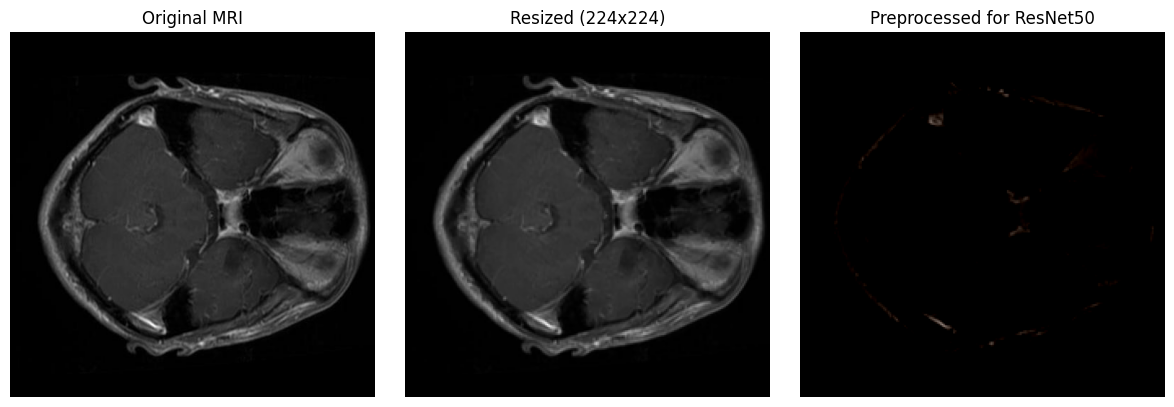

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input  # ResNet50-specific
from PIL import Image

# Load a sample image
img_path = "D:/pe2/dataset/valid/0/brain_glioma_0053.jpg"  # Replace with actual MRI image path
img = Image.open(img_path).convert("RGB")  # Ensure image is in RGB
img_resized = img.resize((224, 224))  # ResNet50 expects 224x224

# Convert to array and preprocess
img_array = np.array(img_resized)
img_array_expanded = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_preprocessed = preprocess_input(img_array_expanded)

# Plot the transformation
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img)  # Original Image
axes[0].set_title("Original MRI")
axes[0].axis("off")

axes[1].imshow(img_resized)  # Resized Image
axes[1].set_title("Resized (224x224)")
axes[1].axis("off")

axes[2].imshow(np.clip(img_preprocessed[0], 0, 255).astype("uint8"))  # Preprocessed Image
axes[2].set_title("Preprocessed for ResNet50")
axes[2].axis("off")

plt.tight_layout()
plt.show()


# 2. Data Distribution (Class Balance)
Since you have three tumor types, you need a bar chart showing how many images per class exist in the dataset.

In [ ]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\suyas\AppData\Local\Temp\ipykernel_16804\1965650647.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Tumor Type", y="Count", data=df, palette="viridis")


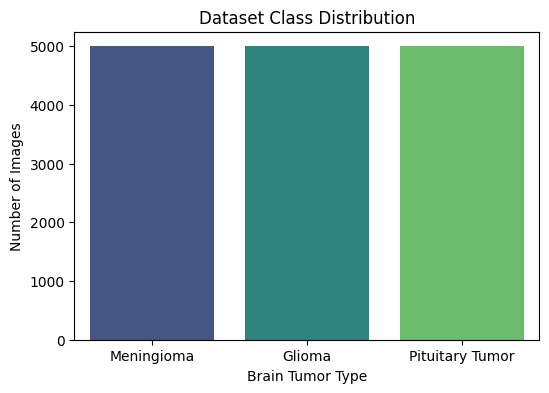

In [ ]:
import seaborn as sns
import pandas as pd

# Simulated class distribution (replace with actual counts)
class_counts = {"Meningioma": 5000, "Glioma": 5000, "Pituitary Tumor": 5000}
df = pd.DataFrame(list(class_counts.items()), columns=["Tumor Type", "Count"])

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x="Tumor Type", y="Count", data=df, palette="viridis")
plt.title("Dataset Class Distribution")
plt.xlabel("Brain Tumor Type")
plt.ylabel("Number of Images")
plt.show()


# 3. Training vs. Validation Accuracy & Loss
You need two line plots:

1. Accuracy over epochs
2. Loss over epochs

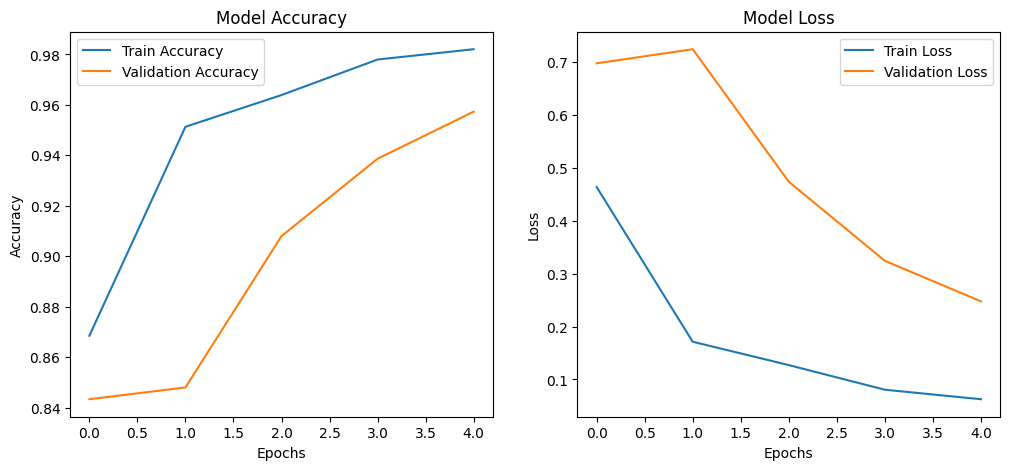

In [ ]:
plt.figure(figsize=(12, 5))

# Training vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(his.history["accuracy"], label="Train Accuracy")
plt.plot(his.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(his.history["loss"], label="Train Loss")
plt.plot(his.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


# 4. Confusion Matrix for Model Evaluation
A confusion matrix helps analyze misclassifications and model performance per class.

c:\Users\suyas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step


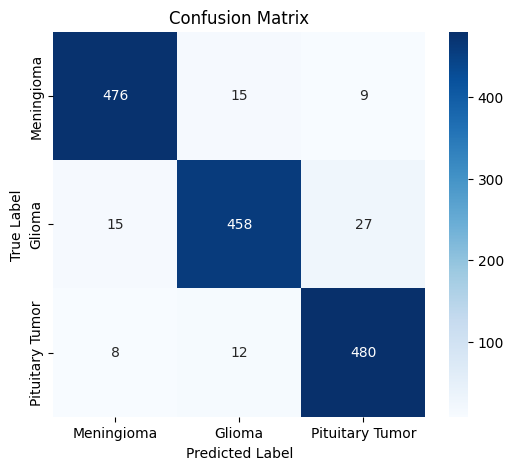

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels & predictions (assuming test_batches is used)
y_true = test_batches.classes
y_pred = np.argmax(model.predict(test_batches), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_labels = {0: "Meningioma", 1: "Glioma", 2: "Pituitary Tumor"}
# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# 5. ROC Curve for Model Performance
ROC (Receiver Operating Characteristic) curve shows how well your model distinguishes tumors.

375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step


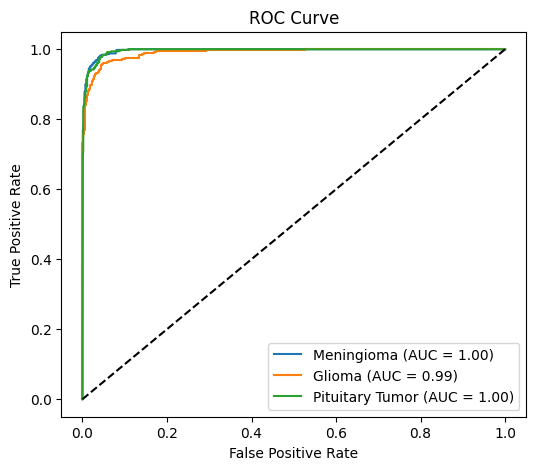

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2])  # 3 classes
y_pred_proba = model.predict(test_batches)

plt.figure(figsize=(6, 5))
for i, label in enumerate(class_labels.values()):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal Line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision, Recall, and F1 Score

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels.values())
print(report)


                 precision    recall  f1-score   support

     Meningioma       0.95      0.95      0.95       500
         Glioma       0.94      0.92      0.93       500
Pituitary Tumor       0.93      0.96      0.94       500

       accuracy                           0.94      1500
      macro avg       0.94      0.94      0.94      1500
   weighted avg       0.94      0.94      0.94      1500

